In [1]:

# %%capture
# If running in Colab, this will install the required libraries.
import sys, subprocess, os

def pip_install(pkgs):
    print("Installing:", pkgs)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs)

pkgs = [
    "transformers>=4.44.0",
    "datasets>=2.20.0",
    "accelerate>=0.33.0",
    "peft>=0.12.0",
    "sentence-transformers>=3.0.1",
    "faiss-cpu>=1.8.0",
    "gradio>=4.44.0",
    "sacrebleu>=2.4.3",
    "evaluate>=0.4.2",
    "rouge-score>=0.1.2",
    # torch is usually preinstalled on Colab; uncomment if needed:
    # "torch==2.3.1",
]

pip_install(pkgs)

print("✅ Setup complete")


Installing: ['transformers>=4.44.0', 'datasets>=2.20.0', 'accelerate>=0.33.0', 'peft>=0.12.0', 'sentence-transformers>=3.0.1', 'faiss-cpu>=1.8.0', 'gradio>=4.44.0', 'sacrebleu>=2.4.3', 'evaluate>=0.4.2', 'rouge-score>=0.1.2']
✅ Setup complete


In [2]:

import os, math, random, re, json, time, gc
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Any, List

import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

from peft import LoraConfig, TaskType, get_peft_model

import evaluate
from sentence_transformers import SentenceTransformer
import faiss
import gradio as gr

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [4]:

# === Load your Aadhaar Services CSV ===
# Expecting columns: ['question', 'answer', 'category', 'keywords', 'official_link']

CSV_PATH = os.environ.get("AADHAAR_CSV_PATH", "aadhaar_dataset_final.csv")  # change if needed

def load_csv(csv_path: str) -> pd.DataFrame:
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        # Try interactive upload (Colab)
        try:
            from google.colab import files
            print("Please upload your CSV (e.g., aadhaar_faq.csv)")
            uploaded = files.upload()
            fname = list(uploaded.keys())[0]
            df = pd.read_csv(fname)
        except Exception as e:
            raise FileNotFoundError(
                f"Dataset not found at {csv_path}. Set CSV_PATH or upload in Colab. Error: {e}"
            )
    expected = {'question','answer','category','keywords','official_link'}
    assert expected.issubset(set(df.columns)), f"CSV must contain columns: {expected}, found: {set(df.columns)}"
    return df

df = load_csv(CSV_PATH)
print("Shape:", df.shape)
df.head(3)


Shape: (1509, 5)


,question,answer,category,keywords,official_link
0,How can I apply for a new Aadhaar card?,Visit your nearest Aadhaar Enrollment Centre w...,Aadhaar,"apply, new, Aadhaar, enrollment",NaN
1,How do I update my Aadhaar address online?,Log in to the UIDAI Self Service Update Portal...,Aadhaar,"update, address, online, Aadhaar",https://uidai.gov.in/en/my-aadhaar/update-aadh...
2,What documents are required for Aadhaar enrolm...,"You need proof of identity, proof of address, ...",Aadhaar,"documents, requirement, Aadhaar, enrolment",https://bhuvan-app3.nrsc.gov.in/aadhaar/


In [5]:

# Basic cleaning
def normalize_text(x: str) -> str:
    if not isinstance(x, str): return ""
    x = x.replace("\u200b"," ").strip()
    x = re.sub(r"\s+", " ", x)
    return x

for col in ["question","answer","category","keywords","official_link"]:
    df[col] = df[col].fillna("").map(normalize_text)

# Drop exact duplicates
df = df.drop_duplicates(subset=["question","answer"]).reset_index(drop=True)

# Stratified split on category when possible
if df["category"].nunique() > 1 and df["category"].value_counts().min() >= 2:
    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["category"], random_state=SEED)
else:
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)

val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))
print("Categories:", df['category'].value_counts().to_dict())

# Create HF datasets
def build_input(row: pd.Series) -> str:
    # For training we include structured fields so the model learns to use them.
    # We'll still RAG-ground at inference from retrieval.
    parts = [
        "You are an official Aadhaar Services Assistant (UIDAI).",
        "Answer strictly and accurately based on Aadhaar guidelines.",
        "If you are unsure, say so and provide the official link for help.",
        f"Category: {row.get('category','')}",
        f"Keywords: {row.get('keywords','')}",
        f"Question: {row.get('question','')}",
        f"OfficialLink: {row.get('official_link','')}",
        "Answer:"
    ]
    return "\n".join(parts)

train_df = train_df.copy()
val_df   = val_df.copy()
test_df  = test_df.copy()

train_df["input_text"] = train_df.apply(build_input, axis=1)
val_df["input_text"]   = val_df.apply(build_input, axis=1)
test_df["input_text"]  = test_df.apply(build_input, axis=1)

train_df["target_text"] = train_df["answer"]
val_df["target_text"]   = val_df["answer"]
test_df["target_text"]  = test_df["answer"]

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df),
})
ds


Train/Val/Test sizes: 1202 150 151
Categories: {'Aadhaar': 957, '': 315, 'Status & Troubleshooting': 41, 'Enrollment': 40, 'E-KYC & Authentication': 39, 'Mobile/Email Updates': 29, 'Biometric Updates': 28, 'Special Cases': 28, 'Address Updates': 26}


DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'category', 'keywords', 'official_link', 'input_text', 'target_text', '__index_level_0__'],
        num_rows: 1202
    })
    validation: Dataset({
        features: ['question', 'answer', 'category', 'keywords', 'official_link', 'input_text', 'target_text', '__index_level_0__'],
        num_rows: 150
    })
    test: Dataset({
        features: ['question', 'answer', 'category', 'keywords', 'official_link', 'input_text', 'target_text', '__index_level_0__'],
        num_rows: 151
    })
})

In [6]:

# Choose base model; small/base recommended for Colab.
MODEL_NAME = "google/flan-t5-base"  # try "google/flan-t5-small" if memory-limited

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

max_input_length = 448
max_target_length = 192

def preprocess(batch):
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
    )

    labels = tokenizer(
        batch["target_text"],
        max_length=max_target_length,
        truncation=True,
        padding="max_length",
    )

    labels_ids = labels["input_ids"]

    # Replace pad_token_id with -100 so they are ignored in loss
    labels_ids = np.where(
        np.array(labels_ids) == tokenizer.pad_token_id,
        -100,
        np.array(labels_ids)
    )

    model_inputs["labels"] = labels_ids
    return model_inputs


tokenized_ds = ds.map(preprocess, batched=True, remove_columns=ds["train"].column_names)
tokenized_ds.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_NAME)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/1202 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [7]:

# Metrics: SacreBLEU & ROUGE-L
bleu = evaluate.load("sacrebleu")
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
#     # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

#     bleu_score = bleu.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])["score"]
#     rouge_l = rouge.compute(predictions=decoded_preds, references=decoded_labels, rouge_types=["rougeL"])["rougeL"].mid.fmeasure

#     return {"bleu": bleu_score, "rougeL": rouge_l}

from evaluate import load

# Load metric once (global)
metric = load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # If model outputs tuple (logits, ...), take argmax
    if isinstance(preds, tuple):
        preds = preds[0]

    # Convert predictions to ids
    preds = np.argmax(preds, axis=-1)

    # Replace -100 in labels with pad_token_id
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Now both are NumPy arrays -> safe for batch_decode
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Postprocess text (strip whitespace etc.)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    # Example metric (BLEU, ROUGE etc.)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

In [8]:

# PEFT LoRA config for seq2seq
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q","v"],  # effective for T5
)

base_model = AutoModelForSeq2SeqLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None,
)

model = get_peft_model(base_model, lora_config)
model.print_trainable_parameters()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

trainable params: 1,769,472 || all params: 249,347,328 || trainable%: 0.7096


In [9]:

output_dir = "/content/aadhaar_t5_lora"

args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    num_train_epochs=3,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    save_total_limit=2,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    # tokenizer=tokenizer,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

train_result = trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print("Best metrics:", trainer.state.best_metric, trainer.state.best_model_checkpoint)


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss,Bleu
1,0.000000,2.914776,0.497459
2,0.000000,2.914776,0.497459
3,0.000000,2.914776,0.497459


Best metrics: 0.4974593302155425 /content/aadhaar_t5_lora/checkpoint-76


In [10]:

# Evaluate on test set
test_metrics = trainer.evaluate(tokenized_ds["test"])
print("Test metrics:", test_metrics)

# Inference helper
def generate_answer(prompt: str, max_new_tokens=192, num_beams=4):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=448).to(model.device)
    with torch.no_grad():
        gen = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            num_beams=num_beams,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.05,
            num_return_sequences=1
        )
    return tokenizer.decode(gen[0], skip_special_tokens=True)

# Quick smoke test on a few samples
for i in range(min(3, len(test_df))):
    row = test_df.iloc[i]
    prompt = row["input_text"]
    pred = generate_answer(prompt)
    print("---")
    print("Q:", row["question"])
    print("Pred:", pred)
    print("Gold:", row["answer"])


Test metrics: {'eval_loss': 2.8664615154266357, 'eval_bleu': 0.5351661927325392, 'eval_runtime': 8.1139, 'eval_samples_per_second': 18.61, 'eval_steps_per_second': 2.342, 'epoch': 3.0}
---
Q: do you study
Pred: Aadhaar
Gold: I don’t study, but I’ve been trained on Aadhaar knowledge.
---
Q: Can I update Aadhaar if my biometrics were captured incorrectly?
Pred: Update Aadhaar if biometrics were captured incorrectly
Gold: Yes, visit the enrollment center to re-enroll your biometrics correctly.
---
Q: Can I update Aadhaar for someone else with authorization?
Pred: Aadhaar Services Assistant (UIDAI)
Gold: No, updates must be done by the Aadhaar holder or legal guardian.


In [11]:

# === Build dense retriever (FAISS + sentence-transformers) ===
# We'll index the full dataset for grounding at inference time.
embed_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(embed_model_name, device=device)

# Text to index (combine question + keywords + category for better recall)
def make_retrieval_text(row):
    return " | ".join([row.get("question",""), row.get("keywords",""), row.get("category","")])

full_df = df.copy().reset_index(drop=True)
texts = full_df.apply(make_retrieval_text, axis=1).tolist()
embeddings = embedder.encode(texts, convert_to_numpy=True, show_progress_bar=True, normalize_embeddings=True)

index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)
print("FAISS index size:", index.ntotal)

def search(query: str, k: int = 5):
    q_emb = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    scores, idxs = index.search(q_emb, k)
    results = []
    for score, idx in zip(scores[0], idxs[0]):
        row = full_df.iloc[int(idx)]
        results.append({
            "score": float(score),
            "question": row["question"],
            "answer": row["answer"],
            "category": row["category"],
            "keywords": row["keywords"],
            "official_link": row["official_link"],
            "row_id": int(idx),
        })
    return results

# Quick retrieval test
print("Retrieval sanity check:", search("How to update mobile number in Aadhaar?", k=3))


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

FAISS index size: 1503
Retrieval sanity check: [{'score': 0.9698629975318909, 'question': 'How do I update my Aadhaar mobile number?', 'answer': 'Visit an enrollment center or use the SSUP portal if your mobile number is already registered.', 'category': 'Aadhaar', 'keywords': 'update, mobile number', 'official_link': '', 'row_id': 532}, {'score': 0.961632490158081, 'question': 'How can I update my mobile number linked to Aadhaar?', 'answer': 'Visit an enrollment center or use the SSUP to update your mobile number.', 'category': 'Aadhaar', 'keywords': 'update, mobile', 'official_link': '', 'row_id': 450}, {'score': 0.9485703706741333, 'question': 'How can I change my Aadhaar mobile number?', 'answer': 'You can update your mobile number at the Aadhaar enrollment center with valid documents.', 'category': 'Aadhaar', 'keywords': 'update, mobile number', 'official_link': '', 'row_id': 562}]


In [12]:

# === Guardrails & Inference (RAG + Generator) ===

# SENSITIVE_PATTERNS = [
#     r"\bshare\b.*\bOTP\b",
#     r"\bOTP\b",
#     r"\bone[-\s]?time password\b",
#     r"\bfull\s*aadhaar\s*number\b",
#     r"\bcard\s*details\b",
#     r"\bpassword\b",
#     r"\bCVV\b",
# ]
# SENSITIVE_RE = re.compile("|".join(SENSITIVE_PATTERNS), re.IGNORECASE)

# SECURITY_MESSAGE = (
#     "For your safety, **never share OTP, passwords, full Aadhaar number, or sensitive personal details here**. "
#     "If you suspect fraud, contact UIDAI helpline 1947. "
# )

import re

# --- Helpers ---
def parse_history(chat_history):
    """
    Supports both:
    - list[tuple(user, bot)]
    - list[dict{role: user|assistant, content: str}]  (Gradio type="messages")
    Returns list[{"user": ..., "bot": ...}]
    """
    if not chat_history:
        return []
    try:
        # messages format
        if isinstance(chat_history[0], dict) and "role" in chat_history[0]:
            hist = []
            last_user = None
            for m in chat_history:
                role = m.get("role")
                content = m.get("content", "")
                if role == "user":
                    last_user = content
                elif role == "assistant":
                    if last_user is None:
                        hist.append({"user": "", "bot": content})
                    else:
                        hist.append({"user": last_user, "bot": content})
                        last_user = None
            return hist
        # tuple/list format
        elif isinstance(chat_history[0], (list, tuple)) and len(chat_history[0]) == 2:
            return [{"user": u, "bot": b} for (u, b) in chat_history if isinstance(u, str) and isinstance(b, str)]
        else:
            return []
    except Exception:
        return []

def build_rag_prompt(user_query: str, history, retrieved):
    context_lines = []
    for i, r in enumerate(retrieved, 1):
        a = r["answer"]
        if len(a) > 400:
            a = a[:400] + "…"
        context_lines.append(
            f"[{i}] Q: {r['question']}\n[{i}] A: {a}\n[{i}] Link: {r.get('official_link','')}"
        )

    history_lines = []
    for turn in history[-3:]:
        history_lines.append(f"User: {turn['user']}")
        history_lines.append(f"Assistant: {turn['bot']}")

    sys_prompt = (
        "You are an official-style Aadhaar Services assistant. Answer ONLY using the context below. "
        "Cite the most relevant link(s). If the answer is not in the context, say you don't know and "
        "suggest the official contact/portal. Be concise, polite, and accurate."
    )

    prompt = (
        sys_prompt + "\n\n"
        + "Context:\n" + "\n".join(context_lines) + "\n\n"
        + ("Conversation so far:\n" + "\n".join(history_lines) + "\n\n" if history_lines else "")
        + f"User question: {user_query}\n"
        + "Assistant answer:"
    )
    return prompt

SENSITIVE_PATTERNS = [
    r"\bshare\b.*\bOTP\b",
    r"\bOTP\b",
    r"\bone[-\s]?time password\b",
    r"\bfull\s*aadhaar\s*number\b",
    r"\bcard\s*details\b",
    r"\bpassword\b",
    r"\bCVV\b",
]

SENSITIVE_RE = re.compile("|".join(SENSITIVE_PATTERNS), re.IGNORECASE)
SECURITY_MESSAGE = (
    "For your safety, **never share OTP, passwords, full Aadhaar number, or sensitive personal details here**. "
    "If you suspect fraud, contact UIDAI helpline 1947."
)

# --- Main bot ---
def aadhaar_bot(user_text, chat_history):
    import traceback
    try:
        if SENSITIVE_RE.search(user_text or ""):
            return SECURITY_MESSAGE + "\nI can't assist with requests that involve sharing sensitive information."

        hist = parse_history(chat_history)

        # Retrieve
        retrieved = search(user_text, k=5) if callable(search) else []
        top = retrieved[0] if retrieved else None
        high_conf = top and top["score"] > 0.65 and len(top.get("answer","").strip()) > 0

        if high_conf:
            ans = top["answer"]
            link = (top.get("official_link") or "").strip()
            if link and link.lower() != "na":
                ans = f"{ans}\n\n**Official link:** {link}"
            return ans

        # RAG + generation
        rag_prompt = build_rag_prompt(user_text, hist, retrieved[:4] if retrieved else [])
        inputs = tokenizer(rag_prompt, return_tensors="pt", truncation=True, max_length=448).to(model.device)

        # Use sampling only if requested; otherwise beam search (no temperature warning)
        gen = model.generate(
            **inputs,
            max_new_tokens=224,
            num_beams=4,           # deterministic & avoids "temperature" warning
            repetition_penalty=1.05,
        )
        out = tokenizer.decode(gen[0], skip_special_tokens=True).strip()

        links = [r.get("official_link") for r in (retrieved or []) if r.get("official_link")]
        if links and ("http://" in out or "https://" in out) is False:
            out += f"\n\nOfficial link: {links[0]}"

        if re.search(r"\bupdate\b.*\bmobile\b|\bKYC\b|\bPAN\b", user_text, re.I):
            out += "\n\n" + SECURITY_MESSAGE

        return out or "Sorry, I couldn't find that in the knowledge base."

    except Exception as e:
        print("Error in aadhaar_bot:", repr(e))
        traceback.print_exc()
        return "Oops — something went wrong processing that. Please try again, or re-run the index build cell."


In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("# Aadhaar Services Assistant (Govt Services)")
    gr.Markdown("Ask anything about Aadhaar updates, address change, e-KYC, PVC, mAadhaar, etc.")

    chat = gr.ChatInterface(
        fn=aadhaar_bot,
        title="Aadhaar Services Chatbot",
        examples=[
            "How to update my mobile number linked with Aadhaar?",
            "What documents are required for address update?",
            "How can I download Aadhaar PVC card?",
            "Is there any fee for biometric update?",
            "How can I check my Aadhaar update status?",
        ],
        cache_examples=False,
        type="messages",   # ← OK now, parser handles this
    )

demo.launch(share=False)  # Basic UI


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [17]:
#without mic but accurate
import re
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sentence_transformers import SentenceTransformer
import faiss
import gradio as gr
import pandas as pd
from datetime import datetime
from difflib import SequenceMatcher
import unicodedata
import numpy as np
from sentence_transformers import util

# === Model and Data Loading ===
model_dir = "aadhaar_t5_lora_final"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = T5ForConditionalGeneration.from_pretrained(
    model_dir,
    torch_dtype=torch.float16 if device == 'cuda' else torch.float32
).to(device)
model.eval()

tokenizer = T5Tokenizer.from_pretrained(model_dir, legacy=False)

# Load FAQ data
faq_df = pd.read_csv("aadhaar_dataset_final1_upd.csv")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
# embed_model = SentenceTransformer('all-mpnet-base-v2')
faq_embeddings = embed_model.encode(faq_df['question'].tolist(), convert_to_numpy=True)

# FAISS index
d = faq_embeddings.shape[1]
quantizer = faiss.IndexFlatIP(d)
faiss_index = faiss.IndexIVFFlat(quantizer, d, min(100, faq_embeddings.shape[0]))
faiss_index.train(faq_embeddings)
faiss_index.add(faq_embeddings)
faiss_index.nprobe = 3

# === Conversation Context Tracking ===
class ConversationContext:
    def __init__(self):
        self.current_topic = None
        self.topic_history = []
        
    def update_context(self, user_input):
        # Detect if this is a follow-up question
        is_follow_up = False
        
        # Check for pronouns that indicate follow-up
        follow_up_pronouns = ['it', 'that', 'this', 'they', 'them']
        if any(pronoun in user_input.lower() for pronoun in follow_up_pronouns):
            is_follow_up = True
        
        # Extract topic from user input
        new_topic = None
        if 'address' in user_input.lower():
            new_topic = 'address_update'
        elif 'mobile' in user_input.lower() or 'phone' in user_input.lower():
            new_topic = 'mobile_update'
        elif 'document' in user_input.lower():
            new_topic = 'documents'
        elif 'cost' in user_input.lower() or 'fee' in user_input.lower():
            new_topic = 'cost'
        
        # Update context based on input
        if new_topic:
            self.current_topic = new_topic
        elif is_follow_up and self.current_topic:
            # Keep current topic for follow-up questions
            pass
        else:
            self.current_topic = None
        
        # Store conversation history
        self.topic_history.append({
            "user_input": user_input,
            "topic": self.current_topic,
            "timestamp": datetime.now()
        })
        
        # Keep only recent history
        if len(self.topic_history) > 5:
            self.topic_history.pop(0)
    
    def get_context_prompt(self):
        if not self.current_topic:
            return ""
        
        topic_map = {
            'address_update': 'address update',
            'mobile_update': 'mobile number update',
            'documents': 'document requirements',
            'cost': 'service fees'
        }
        
        return f"Current Context: Discussing {topic_map.get(self.current_topic, self.current_topic)}"

# Initialize conversation context
conv_context = ConversationContext()

# === UI Configuration ===
css = """
#chat-container {
    height: 65vh;
    overflow-y: auto;
    padding: 15px;
    background: white;
    border-radius: 10px;
    box-shadow: 0 2px 10px rgba(0,0,0,0.1);
    margin-bottom: 15px;
}
.user-message {
    background: #0078d4;
    color: white;
    border-radius: 18px 18px 0 18px;
    padding: 10px 15px;
    margin: 8px 0;
    max-width: 80%;
    float: right;
    clear: both;
}
.bot-message {
    background: #f1f1f1;
    color: #333;
    border-radius: 18px 18px 18px 0;
    padding: 10px 15px;
    margin: 8px 0;
    max-width: 80%;
    float: left;
    clear: both;
}
.typing {
    display: inline-block;
    width: 8px;
    height: 8px;
    border-radius: 50%;
    background: #ccc;
    margin: 0 2px;
    animation: typing 1.4s infinite ease-in-out;
}
@keyframes typing {
    0%, 60%, 100% { transform: translateY(0); }
    30% { transform: translateY(-5px); }
}
.welcome-box {
    background: #e3f2fd;
    border-radius: 10px;
    padding: 20px;
    margin-bottom: 20px;
    border-left: 5px solid #0078d4;
    color: #333;
}

.welcome-box h3 {
    color: #0078d4;
    margin-top: 0;
}

.welcome-box ul {
    margin-bottom: 0;
    padding-left: 20px;
}

.welcome-box li {
    color: #333;
    margin-bottom: 8px;
}

.welcome-box p {
    color: #333;
    margin-bottom: 12px;
}

.welcome-box, 
.welcome-box * {
    color: #000 !important;
}

.suggested-questions {
    display: flex;
    flex-wrap: wrap;
    gap: 8px;
    margin-top: 10px;
}
.suggested-question-btn {
    padding: 6px 12px;
    background: #e3f2fd;
    border: 1px solid #0078d4;
    border-radius: 16px;
    cursor: pointer;
    font-size: 0.9em;
    color: #0078d4;
}
.suggested-question-btn:hover {
    background: #0078d4;
    color: white;
}
"""

# Then update your welcome message Markdown to use proper HTML structure:
welcome_msg = """
<div class='welcome-box' style='color: black;'>
    <h3>Welcome to Aadhaar Services Assistant!</h3>
    <p>I can help you with:</p>
    <ul>
        <li><strong>Aadhaar updates</strong> (name, address, date of birth)</li>
        <li><strong>e-KYC and authentication</strong> services</li>
        <li><strong>mAadhaar app</strong> questions and troubleshooting</li>
        <li><strong>PVC card</strong> requests and tracking</li>
    </ul>
    <p>Try asking:</p>
    <div class='suggested-questions'>
        <div class='suggested-question-btn' onclick="window.dispatchEvent(new CustomEvent('suggested_question', {detail: 'How to update address in Aadhaar?'}))">How to update address?</div>
        <div class='suggested-question-btn' onclick="window.dispatchEvent(new CustomEvent('suggested_question', {detail: 'What documents are needed for mobile update?'}))">Documents for mobile update</div>
        <div class='suggested-question-btn' onclick="window.dispatchEvent(new CustomEvent('suggested_question', {detail: 'How to download e-Aadhaar?'}))">Download e-Aadhaar</div>
    </div>
</div>
"""


# === Helper Functions ===
def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\b(aadhaar|aadhar|adhaar|adhhar)\b', 'aadhaar', text)
    return text.strip()

def parse_history(chat_history):
    if not chat_history:
        return []
    hist = []
    last_user = None
    for m in chat_history:
        if isinstance(m, tuple):
            hist.append({"user": m[0], "bot": m[1]})
        elif isinstance(m, dict):
            role = m.get("role")
            content = m.get("content", "")
            if role == "user":
                last_user = content
            elif role == "assistant":
                hist.append({"user": last_user or "", "bot": content})
                last_user = None
    return hist

def retrieve_faq(query, k=3):
    query_emb = embed_model.encode([query], convert_to_numpy=True)
    D, I = faiss_index.search(query_emb, k)
    results = []
    for idx, score in zip(I[0], D[0]):
        if idx >= 0:
            results.append({
                "question": faq_df.iloc[idx]['question'],
                "answer": faq_df.iloc[idx]['answer'],
                "official_link": faq_df.iloc[idx]['official_link'] if pd.notna(faq_df.iloc[idx]['official_link']) else None,
                "score": float(1 - score)
            })
    return sorted(results, key=lambda x: x['score'], reverse=True)

def build_rag_prompt(user_query, history, retrieved, context_prompt=""):
    context_lines = []
    for i, r in enumerate(retrieved[:2], 1):
        a = r["answer"]
        if len(a) > 300:
            a = a[:300] + "…"
        line = f"[{i}] Q: {r['question']}\n[{i}] A: {a}"
        if r.get("official_link"):
            line += f"\n[{i}] Link: {r['official_link']}"
        context_lines.append(line)

    history_lines = []
    for turn in history[-3:]:  # Keep only last 3 exchanges
        history_lines.append(f"User: {turn['user']}")
        history_lines.append(f"Assistant: {turn['bot']}")

    sys_prompt = (
        "You are an official Aadhaar Services assistant. "
        "Answer concisely using the context below. "
        "Maintain conversation context when needed. "
        "Cite relevant links when available."
    )

    prompt = (
        sys_prompt + "\n\n"
        + "Context:\n" + "\n".join(context_lines) + "\n\n"
        + (context_prompt + "\n\n" if context_prompt else "")
        + ("Recent conversation:\n" + "\n".join(history_lines) + "\n\n" if history_lines else "")
        + f"User question: {user_query}\n"
        + "Assistant answer:"
    )
    return prompt

def is_repetitive(user_text, bot_text, threshold=0.7):
    ratio = SequenceMatcher(None, user_text.lower(), bot_text.lower()).ratio()
    return ratio > threshold

def aadhaar_bot(user_text, chat_history):
    try:
        # Sensitive query check
        SENSITIVE_PATTERNS = [
            r"\bshare\b.*\bOTP\b",        # sharing OTP
            r"\benter\b.*\bOTP\b",        # asking user to enter OTP
            r"\bgive\b.*\bOTP\b",         # requesting OTP
            r"\bsend\b.*\bOTP\b",         # asking to send OTP
            r"\bdisclose\b.*\bOTP\b",     # disclosure
            r"\bfull\s*aadhaar\s*number\b",
            r"\bcard\s*details\b",
            r"\bpassword\b",
            r"\bCVV\b",
        ]
        SENSITIVE_RE = re.compile("|".join(SENSITIVE_PATTERNS), re.IGNORECASE)
        SECURITY_MESSAGE = """
        <div style='background:#fff3f3;padding:10px;border-radius:8px;border-left:4px solid #ff4444'>
            <b>⚠️ Security Notice:</b><br>
            Never share OTPs, passwords, or full Aadhaar numbers here.<br>
            Contact UIDAI helpline <b>1947</b> if you suspect fraud.
        </div>
        """
        if SENSITIVE_RE.search(user_text or ""):
            return SECURITY_MESSAGE

        # Update conversation context
        conv_context.update_context(user_text)
        context_prompt = conv_context.get_context_prompt()

        # Parse chat history
        hist = parse_history(chat_history)

        # Retrieve FAQs
        retrieved = retrieve_faq(user_text, k=3)

        # Initialize answer
        ans = None

        # High-confidence retrieval
        if retrieved and retrieved[0]['score'] > 0.65:
            top = retrieved[0]
            ans = top["answer"]
            if top.get("official_link"):
                ans += f"\n\n<b>Official link:</b> {top['official_link']}"

        # RAG generation if retrieval is low confidence
        if not ans:
            rag_prompt = build_rag_prompt(user_text, hist, retrieved, context_prompt)
            inputs = tokenizer(rag_prompt, return_tensors="pt", truncation=True, max_length=384).to(device)
            with torch.inference_mode():
                gen = model.generate(
                    **inputs,
                    max_new_tokens=150,
                    num_beams=2,
                    do_sample=False,
                    early_stopping=True,
                    repetition_penalty=2.5  # Reduce repetition
                )
            ans = tokenizer.decode(gen[0], skip_special_tokens=True).strip()

        # Fallback check for off-topic or repetitive answers
        if not ans or len(ans.split()) < 3 or is_repetitive(user_text, ans):
            ans = "I'm here to help with Aadhaar services. Could you please ask an Aadhaar-related question?"

        # Attach top official link if any and not already included
        links = [r.get("official_link") for r in retrieved if r.get("official_link")]
        if links and "http" not in ans:
            ans += f"\n\n<b>Official link:</b> {links[0]}"

        return ans

    except Exception as e:
        print(f"Error: {str(e)}")
        return "I couldn’t find an exact answer. Please check the official UIDAI site here: https://uidai.gov.in/en"

# === Gradio UI ===
def add_text(history, text):
    history = history + [(text, None)]
    return history, ""

def bot(history):
    user_text = history[-1][0]
    bot_response = aadhaar_bot(user_text, history[:-1])
    history[-1] = (user_text, bot_response)
    return history

with gr.Blocks(css=css) as demo:
    gr.Markdown("""
    <div style='display:flex;align-items:center;margin-bottom:20px'>
        <img src='https://upload.wikimedia.org/wikipedia/en/thumb/c/cf/Aadhaar_Logo.svg/1200px-Aadhaar_Logo.svg.png' 
             style='width:50px;height:50px;margin-right:15px'>
        <div>
            <h1 style='margin:0;color:#0078d4'>Aadhaar Services Assistant</h1>
            <p style='margin:0;color:#fff'>Official information about Aadhaar services</p>
        </div>
    </div>
    """)
    
    with gr.Column():
        # Welcome message
        gr.HTML(welcome_msg)
        
        # Chat container
        chatbot = gr.Chatbot(
            elem_id="chat-container",
            bubble_full_width=False,
            avatar_images=(
                "https://img.icons8.com/color/48/user-male-circle--v1.png", 
                "https://img.icons8.com/color/48/india-circular.png"
            )
        )
        
        # Input area
        with gr.Row():
            txt = gr.Textbox(
                scale=4,
                show_label=False,
                placeholder="Ask about Aadhaar services...",
                container=False
            )
            btn = gr.Button("Send", scale=1)
        
        # Quick reply examples
        gr.Examples(
            examples=[
                "How to update mobile number?",
                "What is mAadhaar?",
                "PVC card application process",
                "How to lock biometrics?"
            ],
            inputs=txt,
            label="Quick Questions"
        )

    # Handle suggested questions
    suggested_question = gr.Textbox(visible=False)
    
    def handle_suggestion(question):
        return question
    
    suggested_question.change(
        handle_suggestion,
        suggested_question,
        txt
    ).then(
        add_text,
        [chatbot, txt],
        [chatbot, txt]
    ).then(
        bot,
        chatbot,
        chatbot
    )

    # Main chat interface
    txt.submit(add_text, [chatbot, txt], [chatbot, txt]).then(
        bot, chatbot, chatbot
    )
    btn.click(add_text, [chatbot, txt], [chatbot, txt]).then(
        bot, chatbot, chatbot
    )

    gr.HTML("""
    <script>
    function setupSuggestedQuestions() {
        document.querySelectorAll('.suggested-question-btn').forEach(btn => {
            btn.addEventListener('click', (e) => {
                const question = e.target.textContent;
                const hiddenInput = document.querySelector('input[type="hidden"]');
                if (hiddenInput) {
                    hiddenInput.value = question;
                    hiddenInput.dispatchEvent(new Event('change', { bubbles: true }));
                }
            });
        });
    }
    setupSuggestedQuestions();
    </script>
    """)

demo.launch() #without mic

C:\Users\pmoha\AppData\Local\Temp\ipykernel_14808\1801910930.py:404: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
C:\Users\pmoha\AppData\Local\Temp\ipykernel_14808\1801910930.py:404: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(


* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


In [19]:
#with mic

import re
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sentence_transformers import SentenceTransformer
import faiss
import gradio as gr
import pandas as pd
from datetime import datetime
from difflib import SequenceMatcher
import unicodedata
import numpy as np
from sentence_transformers import util

# === Model and Data Loading ===
model_dir = "aadhaar_t5_lora_final"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load model
model = T5ForConditionalGeneration.from_pretrained(
    model_dir,
    torch_dtype=torch.float16 if device == 'cuda' else torch.float32
).to(device)
model.eval()

tokenizer = T5Tokenizer.from_pretrained(model_dir, legacy=False)

# Load FAQ data
faq_df = pd.read_csv("aadhaar_dataset_final1_upd.csv")
embed_model = SentenceTransformer('all-MiniLM-L6-v2')
# embed_model = SentenceTransformer('all-mpnet-base-v2')
faq_embeddings = embed_model.encode(faq_df['question'].tolist(), convert_to_numpy=True)

# FAISS index
d = faq_embeddings.shape[1]
quantizer = faiss.IndexFlatIP(d)
faiss_index = faiss.IndexIVFFlat(quantizer, d, min(100, faq_embeddings.shape[0]))
faiss_index.train(faq_embeddings)
faiss_index.add(faq_embeddings)
faiss_index.nprobe = 3

# === Conversation Context Tracking ===
class ConversationContext:
    def __init__(self):
        self.current_topic = None
        self.topic_history = []
        
    def update_context(self, user_input):
        # Detect if this is a follow-up question
        is_follow_up = False
        
        # Check for pronouns that indicate follow-up
        follow_up_pronouns = ['it', 'that', 'this', 'they', 'them']
        if any(pronoun in user_input.lower() for pronoun in follow_up_pronouns):
            is_follow_up = True
        
        # Extract topic from user input
        new_topic = None
        if 'address' in user_input.lower():
            new_topic = 'address_update'
        elif 'mobile' in user_input.lower() or 'phone' in user_input.lower():
            new_topic = 'mobile_update'
        elif 'document' in user_input.lower():
            new_topic = 'documents'
        elif 'cost' in user_input.lower() or 'fee' in user_input.lower():
            new_topic = 'cost'
        
        # Update context based on input
        if new_topic:
            self.current_topic = new_topic
        elif is_follow_up and self.current_topic:
            # Keep current topic for follow-up questions
            pass
        else:
            self.current_topic = None
        
        # Store conversation history
        self.topic_history.append({
            "user_input": user_input,
            "topic": self.current_topic,
            "timestamp": datetime.now()
        })
        
        # Keep only recent history
        if len(self.topic_history) > 5:
            self.topic_history.pop(0)
    
    def get_context_prompt(self):
        if not self.current_topic:
            return ""
        
        topic_map = {
            'address_update': 'address update',
            'mobile_update': 'mobile number update',
            'documents': 'document requirements',
            'cost': 'service fees'
        }
        
        return f"Current Context: Discussing {topic_map.get(self.current_topic, self.current_topic)}"

# Initialize conversation context
conv_context = ConversationContext()

# ---- Optional: local Text-to-Speech via pyttsx3 (offline) ----
# pip install pyttsx3 pydub
import os
import uuid

def tts_audio(text: str, out_dir="tts_cache"):
    try:
        import pyttsx3
    except ImportError:
        return None  # not available

    os.makedirs(out_dir, exist_ok=True)
    fn = os.path.join(out_dir, f"{uuid.uuid4().hex}.wav")
    try:
        engine = pyttsx3.init()
        engine.setProperty('rate', 170)
        engine.save_to_file(text, fn)
        engine.runAndWait()
        return fn
    except Exception:
        return None


# ---- Optional: speech-to-text via OpenAI Whisper local (if installed) ----
# pip install openai-whisper
def stt_transcribe(audio_path: str) -> str:
    if not audio_path:
        return ""
    try:
        import whisper
        model = whisper.load_model("base")  # 'tiny' for speed
        result = model.transcribe(audio_path)
        return result.get("text", "").strip()
    except Exception:
        return ""  # fallback: empty → no transcript


# === UI Configuration ===
css = """
#chat-container {
    height: 65vh;
    overflow-y: auto;
    padding: 15px;
    background: white;
    border-radius: 10px;
    box-shadow: 0 2px 10px rgba(0,0,0,0.1);
    margin-bottom: 15px;
}
.user-message {
    background: #0078d4;
    color: white;
    border-radius: 18px 18px 0 18px;
    padding: 10px 15px;
    margin: 8px 0;
    max-width: 80%;
    float: right;
    clear: both;
}
.bot-message {
    background: #f1f1f1;
    color: #333;
    border-radius: 18px 18px 18px 0;
    padding: 10px 15px;
    margin: 8px 0;
    max-width: 80%;
    float: left;
    clear: both;
}
.typing {
    display: inline-block;
    width: 8px;
    height: 8px;
    border-radius: 50%;
    background: #ccc;
    margin: 0 2px;
    animation: typing 1.4s infinite ease-in-out;
}
@keyframes typing {
    0%, 60%, 100% { transform: translateY(0); }
    30% { transform: translateY(-5px); }
}
.welcome-box {
    background: #e3f2fd;
    border-radius: 10px;
    padding: 20px;
    margin-bottom: 20px;
    border-left: 5px solid #0078d4;
    color: #333;
}

.welcome-box h3 {
    color: #0078d4;
    margin-top: 0;
}

.welcome-box ul {
    margin-bottom: 0;
    padding-left: 20px;
}

.welcome-box li {
    color: #333;
    margin-bottom: 8px;
}

.welcome-box p {
    color: #333;
    margin-bottom: 12px;
}

.welcome-box, 
.welcome-box * {
    color: #000 !important;
}

.suggested-questions {
    display: flex;
    flex-wrap: wrap;
    gap: 8px;
    margin-top: 10px;
}
.suggested-question-btn {
    padding: 6px 12px;
    background: #e3f2fd;
    border: 1px solid #0078d4;
    border-radius: 16px;
    cursor: pointer;
    font-size: 0.9em;
    color: #0078d4;
}
.suggested-question-btn:hover {
    background: #0078d4;
    color: white;
}
"""

# Then update your welcome message Markdown to use proper HTML structure:
welcome_msg = """
<div class='welcome-box' style='color: black;'>
    <h3>Welcome to Aadhaar Services Assistant!</h3>
    <p>I can help you with:</p>
    <ul>
        <li><strong>Aadhaar updates</strong> (name, address, date of birth)</li>
        <li><strong>e-KYC and authentication</strong> services</li>
        <li><strong>mAadhaar app</strong> questions and troubleshooting</li>
        <li><strong>PVC card</strong> requests and tracking</li>
    </ul>
    <p>Try asking:</p>
    <div class='suggested-questions'>
        <div class='suggested-question-btn' onclick="window.dispatchEvent(new CustomEvent('suggested_question', {detail: 'How to update address in Aadhaar?'}))">How to update address?</div>
        <div class='suggested-question-btn' onclick="window.dispatchEvent(new CustomEvent('suggested_question', {detail: 'What documents are needed for mobile update?'}))">Documents for mobile update</div>
        <div class='suggested-question-btn' onclick="window.dispatchEvent(new CustomEvent('suggested_question', {detail: 'How to download e-Aadhaar?'}))">Download e-Aadhaar</div>
    </div>
</div>
"""


# === Helper Functions ===
def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\b(aadhaar|aadhar|adhaar|adhhar)\b', 'aadhaar', text)
    return text.strip()

def parse_history(chat_history):
    if not chat_history:
        return []
    hist = []
    last_user = None
    for m in chat_history:
        if isinstance(m, tuple):
            hist.append({"user": m[0], "bot": m[1]})
        elif isinstance(m, dict):
            role = m.get("role")
            content = m.get("content", "")
            if role == "user":
                last_user = content
            elif role == "assistant":
                hist.append({"user": last_user or "", "bot": content})
                last_user = None
    return hist

def retrieve_faq(query, k=3):
    query_emb = embed_model.encode([query], convert_to_numpy=True)
    D, I = faiss_index.search(query_emb, k)
    results = []
    for idx, score in zip(I[0], D[0]):
        if idx >= 0:
            results.append({
                "question": faq_df.iloc[idx]['question'],
                "answer": faq_df.iloc[idx]['answer'],
                "official_link": faq_df.iloc[idx]['official_link'] if pd.notna(faq_df.iloc[idx]['official_link']) else None,
                "score": float(1 - score)
            })
    return sorted(results, key=lambda x: x['score'], reverse=True)

def build_rag_prompt(user_query, history, retrieved, context_prompt=""):
    context_lines = []
    for i, r in enumerate(retrieved[:2], 1):
        a = r["answer"]
        if len(a) > 300:
            a = a[:300] + "…"
        line = f"[{i}] Q: {r['question']}\n[{i}] A: {a}"
        if r.get("official_link"):
            line += f"\n[{i}] Link: {r['official_link']}"
        context_lines.append(line)

    history_lines = []
    for turn in history[-3:]:  # Keep only last 3 exchanges
        history_lines.append(f"User: {turn['user']}")
        history_lines.append(f"Assistant: {turn['bot']}")

    sys_prompt = (
        "You are an official Aadhaar Services assistant. "
        "Answer concisely using the context below. "
        "Maintain conversation context when needed. "
        "Cite relevant links when available."
    )

    prompt = (
        sys_prompt + "\n\n"
        + "Context:\n" + "\n".join(context_lines) + "\n\n"
        + (context_prompt + "\n\n" if context_prompt else "")
        + ("Recent conversation:\n" + "\n".join(history_lines) + "\n\n" if history_lines else "")
        + f"User question: {user_query}\n"
        + "Assistant answer:"
    )
    return prompt

# --- Simple short-term memory (last few turns) ---
class ConversationMemory:
    """
    Tracks the last explicit topic + intent so follow-ups like
    'what documents are required for it' resolve correctly.
    """
    def __init__(self, max_turns=6):
        self.max_turns = max_turns
        self.turns = []   # [{user, bot, topic, intent}]
        self.last_topic = None
        self.last_intent = None

    def update(self, user_text, bot_text, topic=None, intent=None):
        if topic:
            self.last_topic = topic
        if intent:
            self.last_intent = intent
        self.turns.append({
            "user": user_text,
            "bot": bot_text,
            "topic": self.last_topic,
            "intent": self.last_intent,
            "ts": datetime.now().isoformat()
        })
        if len(self.turns) > self.max_turns:
            self.turns.pop(0)

    def resolve_followup(self, user_text):
        """
        If the user used anaphora (it/that/this) or asked a generic question
        (e.g., 'what documents are required'), return the last known topic/intent.
        """
        text = user_text.lower()
        anaphora = any(w in text for w in [" it", " that", " this", " them", " they"])
        generic_docs_q = re.search(r"\b(documents|docs|proof)\b", text) and not re.search(r"\b(address|mobile|phone|name|dob|date of birth|gender|biometric|pvc)\b", text)
        generic_fee_q  = re.search(r"\b(cost|fee|charges?)\b", text) and not re.search(r"\b(address|mobile|phone|name|dob|date of birth|gender|biometric|pvc)\b", text)

        # If the user already stated a topic in this turn, don't force memory
        stated_topic, _ = detect_topic_and_intent(user_text)

        if stated_topic:
            return stated_topic, None  # caller will compute intent again
        if anaphora or generic_docs_q or generic_fee_q:
            return self.last_topic, self.last_intent
        return None, None

# Shared memory instance (global)
mem = ConversationMemory()


# --- Topic & Intent detector (static, fast, no external libs) ---
TOPIC_KEYWORDS = {
    "address_update":  ["address", "residence", "location"],
    "mobile_update":   ["mobile", "phone", "number", "cell"],
    "name_update":     ["name", "spelling", "rename"],
    "dob_update":      ["dob", "date of birth", "birth"],
    "gender_update":   ["gender", "sex"],
    "biometric_lock":  ["biometric", "fingerprint", "iris", "lock", "unlock"],
    "pvc_card":        ["pvc", "plastic", "card"],
}

INTENT_KEYWORDS = {
    "how_to":          ["how", "procedure", "process", "steps", "update", "change"],
    "documents":       ["document", "documents", "docs", "proof", "poa", "poi", "por", "dob"],
    "fees":            ["cost", "fee", "charges", "price", "rs", "₹"],
    "status":          ["status", "track", "tracking"],
}

def detect_topic_and_intent(text: str):
    t = text.lower()
    topic = None
    intent = None

    # Topic
    topic_hits = []
    for tname, kws in TOPIC_KEYWORDS.items():
        if any(kw in t for kw in kws):
            topic_hits.append(tname)
    if topic_hits:
        # pick the most specific (longest keyword matched -> crude proxy)
        topic = topic_hits[0]

    # Intent
    for iname, kws in INTENT_KEYWORDS.items():
        if any(kw in t for kw in kws):
            intent = iname
            break

    return topic, intent


# --- Query rewriter using memory ---
def rewrite_query_with_memory(user_text: str) -> str:
    """
    Turn follow-ups like 'What documents are required for it?'
    into dataset-friendly queries like:
    'What documents are required for address update?'
    """
    topic_map_to_human = {
        "address_update": "address update",
        "mobile_update": "mobile update",
        "name_update": "name update",
        "dob_update": "date of birth update",
        "gender_update": "gender update",
        "biometric_lock": "biometric lock/unlock",
        "pvc_card": "PVC card",
    }

    # Detect current turn topic/intent
    stated_topic, stated_intent = detect_topic_and_intent(user_text)

    # Try resolving from memory if needed
    mem_topic, mem_intent = mem.resolve_followup(user_text)

    topic = stated_topic or mem_topic
    intent = stated_intent or mem_intent

    # If the user asked about "documents" but didn't say topic, use memory topic
    needs_topic = re.search(r"\b(documents|docs|proof|fee|cost|charges?)\b", user_text.lower())
    if needs_topic and not topic:
        # No topic available → return original, system will answer generally
        return user_text

    # Build a clearer query for retrieval
    if topic:
        human_topic = topic_map_to_human.get(topic, topic.replace("_", " "))
        # Intent-specific rewrites
        if re.search(r"\b(documents|docs|proof)\b", user_text.lower()) or intent == "documents":
            return f"What documents are required for {human_topic}?"
        if re.search(r"\b(cost|fee|charges?)\b", user_text.lower()) or intent == "fees":
            return f"What is the fee for {human_topic}?"
        if re.search(r"\bhow\b|\bsteps?\b|\bprocess\b|\bprocedure\b|\bupdate\b", user_text.lower()) or intent == "how_to":
            return f"How to do {human_topic}?"
        if re.search(r"\bstatus|track\b", user_text.lower()) or intent == "status":
            return f"How to check status for {human_topic}?"

    # default: original
    return user_text


def is_repetitive(user_text, bot_text, threshold=0.7):
    ratio = SequenceMatcher(None, user_text.lower(), bot_text.lower()).ratio()
    return ratio > threshold

def aadhaar_bot(user_text, chat_history):
    try:
        # Sensitive query check
        SENSITIVE_PATTERNS = [
            r"\bshare\b.*\bOTP\b",        # sharing OTP
            r"\benter\b.*\bOTP\b",        # asking user to enter OTP
            r"\bgive\b.*\bOTP\b",         # requesting OTP
            r"\bsend\b.*\bOTP\b",         # asking to send OTP
            r"\bdisclose\b.*\bOTP\b",     # disclosure
            r"\bfull\s*aadhaar\s*number\b",
            r"\bcard\s*details\b",
            r"\bpassword\b",
            r"\bCVV\b",
        ]
        SENSITIVE_RE = re.compile("|".join(SENSITIVE_PATTERNS), re.IGNORECASE)
        SECURITY_MESSAGE = """
        <div style='background:#fff3f3;padding:10px;border-radius:8px;border-left:4px solid #ff4444'>
            <b>⚠️ Security Notice:</b><br>
            Never share OTPs, passwords, or full Aadhaar numbers here.<br>
            Contact UIDAI helpline <b>1947</b> if you suspect fraud.
        </div>
        """
        if SENSITIVE_RE.search(user_text or ""):
            return SECURITY_MESSAGE

        # Update conversation context
        conv_context.update_context(user_text)
        context_prompt = conv_context.get_context_prompt()

        # Parse chat history
        hist = parse_history(chat_history)
        
        # --- Step 1: detect topic for this query
        stated_topic, stated_intent = detect_topic_and_intent(user_text)

        # --- Step 2: check if it's a follow-up
        mem_topic, mem_intent = mem.resolve_followup(user_text)

        # --- Step 3: decide whether to rewrite or use raw
        if mem_topic and not stated_topic:
            # follow-up detected → rewrite query with memory
            enriched_query = rewrite_query_with_memory(user_text)
        else:
            # independent/new query → use raw user_text
            enriched_query = user_text
            
        if mem_topic and not stated_topic:
            # Only rewrite if the user query is generic or clearly missing topic
            if re.search(r'\b(documents|fee|cost|charges?|it|this|that|them|they)\b', user_text.lower()):
                enriched_query = rewrite_query_with_memory(user_text)
            else:
                enriched_query = user_text  # keep original if the query is specific
        else:
            enriched_query = user_text


        # # --- (C) Rewrite query using memory so follow-ups resolve ---
        # enriched_query = rewrite_query_with_memory(user_text)
        
        # Retrieve FAQs
        # retrieved = retrieve_faq(user_text, k=3)
        
        # --- (D) Retrieve with enriched query ---
        retrieved = retrieve_faq(enriched_query, k=3)

        # Initialize answer
        ans = None

        # High-confidence retrieval
        if retrieved and retrieved[0]['score'] > 0.65:
            top = retrieved[0]
            ans = top["answer"]
            if top.get("official_link"):
                ans += f"\n\n<b>Official link:</b> {top['official_link']}"

        # RAG generation if retrieval is low confidence
        if not ans:
            context_prompt = ""  # optional: mem summary if you want
            rag_prompt = build_rag_prompt(user_text, hist, retrieved, context_prompt)
            inputs = tokenizer(rag_prompt, return_tensors="pt", truncation=True, max_length=384).to(device)
            with torch.inference_mode():
                gen = model.generate(
                    **inputs,
                    max_new_tokens=150,
                    num_beams=2,
                    do_sample=False,
                    early_stopping=True,
                    repetition_penalty=2.5  # Reduce repetition
                )
            ans = tokenizer.decode(gen[0], skip_special_tokens=True).strip()

        # Fallback check for off-topic or repetitive answers
        if not ans or len(ans.split()) < 3 or is_repetitive(user_text, ans):
            ans = "I'm here to help with Aadhaar services. Could you please ask an Aadhaar-related question?"

        # Attach top official link if any and not already included
        links = [r.get("official_link") for r in retrieved if r.get("official_link")]
        if links and "http" not in ans:
            ans += f"\n\n<b>Official link:</b> {links[0]}"
        
        # --- (H) UPDATE MEMORY with the resolved topic/intent for next turn ---
        resolved_topic, resolved_intent = detect_topic_and_intent(enriched_query)
        mem.update(user_text, ans, topic=resolved_topic, intent=resolved_intent)

        
        return ans

    except Exception as e:
        print(f"Error: {str(e)}")
        return "I couldn’t find an exact answer. Please check the official UIDAI site here: https://uidai.gov.in/en"

# === Gradio UI ===
def add_text(history, text):
    history = history + [(text, None)]
    return history, ""

def bot(history, speak_reply):
    user_text = history[-1][0]
    bot_response = aadhaar_bot(user_text, history[:-1])
    history[-1] = (user_text, bot_response)

    # Optional TTS
    audio_path = None
    if speak_reply:
        audio_path = tts_audio(bot_response)

    return history, audio_path

def transcribe_and_send(history, audio_path):
    if not audio_path:  # safety check
        txt = "(1 Could not transcribe audio. Please type your question.)"
    else:
        print("Audio path:", audio_path)
        try:
            txt = stt_transcribe(audio_path)
            if not txt:
                txt = "(2 Could not transcribe audio. Please type your question.)"
        except Exception as e:
            print("STT error:", e)
            txt = "(3 Could not transcribe audio. Please type your question.)"
    
    history = history + [[txt, ""]]  # always a list of 2 elements
    return history

with gr.Blocks(css=css) as demo:
    gr.Markdown("""
    <div style='display:flex;align-items:center;margin-bottom:20px'>
        <img src='https://upload.wikimedia.org/wikipedia/en/thumb/c/cf/Aadhaar_Logo.svg/1200px-Aadhaar_Logo.svg.png' 
             style='width:50px;height:50px;margin-right:15px'>
        <div>
            <h1 style='margin:0;color:#0078d4'>Aadhaar Services Assistant</h1>
            <p style='margin:0;color:#666'>Official information about Aadhaar services</p>
        </div>
    </div>
    """)
    
    with gr.Column():
        # Welcome message
        gr.HTML(welcome_msg)
        
        # Chat container
        chatbot = gr.Chatbot(
            elem_id="chat-container",
            bubble_full_width=False,
            avatar_images=(
                "https://img.icons8.com/color/48/user-male-circle--v1.png", 
                "https://img.icons8.com/color/48/india-circular.png"
            )
        )
        
        # Input area
        with gr.Row():
            txt = gr.Textbox(
                scale=4,
                show_label=False,
                placeholder="Ask about Aadhaar services...",
                container=False
            )
            speak_chk = gr.Checkbox(label="🔊 Speak replies", value=False)
            btn = gr.Button("Send", scale=1)
            
                # Voice input row (optional)
        with gr.Row():
            mic = gr.Microphone(label="🎙️ Speak your question (optional)",type="filepath")
            mic_btn = gr.Button("Transcribe & Send")
        tts_audio_out = gr.Audio(type="filepath", label="Assistant voice", autoplay=True)

        
        # Quick reply examples
        gr.Examples(
            examples=[
                "How to update mobile number?",
                "What is mAadhaar?",
                "PVC card application process",
                "How to lock biometrics?"
            ],
            inputs=txt,
            label="Quick Questions"
        )
    
    
    # --- Text input triggers ---
    txt.submit(add_text, [chatbot, txt], [chatbot, txt]).then(
        bot, [chatbot, speak_chk], [chatbot, tts_audio_out]
    )
    btn.click(add_text, [chatbot, txt], [chatbot, txt]).then(
        bot, [chatbot, speak_chk], [chatbot, tts_audio_out]
    )
    
    # --- Voice input triggers ---
    mic_btn.click(transcribe_and_send, [chatbot, mic], [chatbot]).then(
        bot, [chatbot, speak_chk], [chatbot, tts_audio_out]
    )
    
        # --- Suggested question triggers ---
    def handle_suggestion(question, chat_history):
        chat_history, _ = add_text(chat_history, question)
        chat_history, audio_path = bot(chat_history, speak_reply=True)
        return chat_history, audio_path

    # Handle suggested questions
    suggested_question = gr.Textbox(visible=False)
    
    # Make sure the input is visible to the function
    suggested_question.change(
        handle_suggestion,
        [suggested_question, chatbot],
        [chatbot, tts_audio_out]
    )
    

    gr.HTML("""
    <script>
    function setupSuggestedQuestions() {
        document.querySelectorAll('.suggested-question-btn').forEach(btn => {
            btn.addEventListener('click', (e) => {
                const question = e.target.textContent;
                const hiddenInput = document.querySelector('input[type="hidden"]');
                if (hiddenInput) {
                    hiddenInput.value = question;
                    hiddenInput.dispatchEvent(new Event('change', { bubbles: true }));
                }
            });
        });
    }
    setupSuggestedQuestions();
    </script>
    """)

demo.launch() #with mic

C:\Users\pmoha\AppData\Local\Temp\ipykernel_14808\468615186.py:640: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(
C:\Users\pmoha\AppData\Local\Temp\ipykernel_14808\468615186.py:640: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(


* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


In [15]:
!zip -r aadhaar_t5_lora.zip aadhaar_t5_lora

  adding: aadhaar_t5_lora/ (stored 0%)
  adding: aadhaar_t5_lora/checkpoint-228/ (stored 0%)
  adding: aadhaar_t5_lora/checkpoint-228/rng_state.pth (deflated 25%)
  adding: aadhaar_t5_lora/checkpoint-228/optimizer.pt (deflated 46%)
  adding: aadhaar_t5_lora/checkpoint-228/adapter_model.safetensors (deflated 70%)
  adding: aadhaar_t5_lora/checkpoint-228/scaler.pt (deflated 60%)
  adding: aadhaar_t5_lora/checkpoint-228/trainer_state.json (deflated 70%)
  adding: aadhaar_t5_lora/checkpoint-228/tokenizer_config.json (deflated 95%)
  adding: aadhaar_t5_lora/checkpoint-228/tokenizer.json (deflated 74%)
  adding: aadhaar_t5_lora/checkpoint-228/special_tokens_map.json (deflated 85%)
  adding: aadhaar_t5_lora/checkpoint-228/scheduler.pt (deflated 56%)
  adding: aadhaar_t5_lora/checkpoint-228/README.md (deflated 66%)
  adding: aadhaar_t5_lora/checkpoint-228/adapter_config.json (deflated 56%)
  adding: aadhaar_t5_lora/checkpoint-228/training_args.bin (deflated 52%)
  adding: aadhaar_t5_lora/check

In [16]:
from google.colab import files
files.download("aadhaar_t5_lora.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
!pip install nltk
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pmoha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
# Load dataset
import pandas as pd
faq_df = pd.read_csv("aadhaar_dataset_final1_upd.csv")

# Store references and predictions
references = []
predictions = []

for i, row in faq_df.iterrows():
    question = row["question"]
    true_answer = row["answer"]

    # Run chatbot to get prediction
    pred_answer = aadhaar_bot(question, [])

    # Tokenize for BLEU
    references.append([true_answer.split()])   # reference must be list of lists
    predictions.append(pred_answer.split())


In [34]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

smooth_fn = SmoothingFunction().method1

# Example: sentence-level BLEU
for i in range(5):
    print(f"Q: {faq_df.iloc[i]['question']}")
    print(f"True: {faq_df.iloc[i]['answer']}")
    print(f"Pred: {' '.join(predictions[i])}")
    print("BLEU:", sentence_bleu([predictions[i]], predictions[i], smoothing_function=smooth_fn))
    print("----")

# Corpus-level BLEU
corpus_bleu_score = corpus_bleu(references, predictions, smoothing_function=smooth_fn)
print("Corpus BLEU Score:", corpus_bleu_score)

Q: How can I apply for a new Aadhaar card?
True: Visit your nearest Aadhaar Enrollment Centre with proof of identity and address, fill the enrollment form, and provide biometrics.
Pred: Visit your nearest Aadhaar Enrollment Centre with proof of identity and address, fill the enrollment form, and provide biometrics. Official link: nan
BLEU: 1.0
----
Q: How do I update my Aadhaar address online?
True: Log in to the UIDAI Self Service Update Portal using your Aadhaar number and OTP, then submit valid address proof.
Pred: Log in to the UIDAI Self Service Update Portal using your Aadhaar number and OTP, then submit valid address proof. Official link: https://uidai.gov.in/en/my-aadhaar/update-aadhaar.html
BLEU: 1.0
----
Q: What documents are required for Aadhaar enrolment?
True: You need proof of identity, proof of address, proof of relationship (if applicable), and date of birth document.
Pred: You need proof of identity, proof of address, proof of relationship (if applicable), and date of 

In [27]:
# =========================
# Extra Evaluation Metrics
# =========================

!pip install rouge-score bert-score

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score
import numpy as np

# -----------------------------
# 1) Preprocess: clean answers
# -----------------------------
def clean_answer(ans: str):
    ans = ans.replace("Official link: https://uidai.gov.in/", "")
    ans = ans.replace("Official link: https://ssup.uidai.gov.in/", "")
    return ans.strip()

true_texts = [clean_answer(row["answer"]) for _, row in faq_df.iterrows()]
pred_texts = [clean_answer(" ".join(pred)) for pred in predictions]

# -----------------------------
# 2) BLEU (same as before)
# -----------------------------
smoother = SmoothingFunction().method1
bleu_scores = [
    sentence_bleu([ref.split()], pred.split(), smoothing_function=smoother)
    for ref, pred in zip(true_texts, pred_texts)
]
corpus_bleu = np.mean(bleu_scores)

# -----------------------------
# 3) ROUGE
# -----------------------------
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(true_texts, pred_texts)]

avg_rouge1 = np.mean([s["rouge1"].fmeasure for s in rouge_scores])
avg_rougeL = np.mean([s["rougeL"].fmeasure for s in rouge_scores])

# -----------------------------
# 4) BERTScore
# -----------------------------
P, R, F1 = score(pred_texts, true_texts, lang="en", verbose=True)
bert_f1 = F1.mean().item()

# -----------------------------
# 5) Print Results
# -----------------------------
print("Corpus BLEU:", corpus_bleu)
print("ROUGE-1 (avg F1):", avg_rouge1)
print("ROUGE-L (avg F1):", avg_rougeL)
print("BERTScore F1:", bert_f1)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/89 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/80 [00:00<?, ?it/s]

done in 36.00 seconds, 140.95 sentences/sec
Corpus BLEU: 0.9409584724133391
ROUGE-1 (avg F1): 0.9465470189138658
ROUGE-L (avg F1): 0.9445616234165831
BERTScore F1: 0.9877134561538696


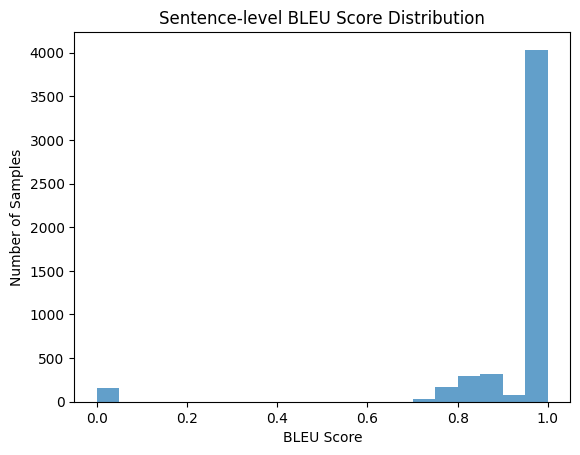

In [35]:
import matplotlib.pyplot as plt

plt.hist(bleu_scores, bins=20, alpha=0.7)
plt.title("Sentence-level BLEU Score Distribution")
plt.xlabel("BLEU Score")
plt.ylabel("Number of Samples")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.hist([b for b in bleu_scores if b < 1.0], bins=20, alpha=0.7, color='orange')
plt.title("Sentence-level BLEU Score Distribution (Excluding 1.0)")
plt.xlabel("BLEU Score")
plt.ylabel("Number of Samples")
plt.show()
